In [6]:
import pandas as pd
import spacy
from spacy.tokens import DocBin
from spacy.training.example import Example
from spacy.util import minibatch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [8]:
import pandas as pd

# Try reading only the first few rows to see if the error persists
try:
    data = pd.read_csv('NER_Dataset.csv', nrows=1000)
    print("Successfully read the first 1000 rows. The issue might be in the later part of the file.")
except pd.errors.ParserError as e:
    print(f"Error still occurs even when reading a smaller portion: {e}")



Successfully read the first 1000 rows. The issue might be in the later part of the file.


In [9]:
data.head()

,Sentence_ID,Word,POS,Tag
0,Sentence: 1,"['Thousands', 'of', 'demonstrators', 'have', '...","['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 10,"['Iranian', 'officials', 'say', 'they', 'expec...","['JJ', 'NNS', 'VBP', 'PRP', 'VBP', 'TO', 'VB',...","['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."
2,Sentence: 100,"['Helicopter', 'gunships', 'Saturday', 'pounde...","['NN', 'NNS', 'NNP', 'VBD', 'JJ', 'NNS', 'IN',...","['O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', '..."
3,Sentence: 1000,"['They', 'left', 'after', 'a', 'tense', 'hour-...","['PRP', 'VBD', 'IN', 'DT', 'NN', 'JJ', 'NN', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 10000,"['U.N.', 'relief', 'coordinator', 'Jan', 'Egel...","['NNP', 'NN', 'NN', 'NNP', 'NNP', 'VBD', 'NNP'...","['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-..."


In [11]:
data['Word'][3]

"['They', 'left', 'after', 'a', 'tense', 'hour-long', 'standoff', 'with', 'riot', 'police', '.']"

In [12]:
data['Tag'][3]

"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"

In [13]:
data.shape

(1000, 4)

In [14]:
# checking for duplicates
duplicates_count=data.duplicated().sum()
duplicates_count

0

In [15]:
# Parse the data
sentences = data['Word'].tolist()
pos_tags = data['POS'].apply(eval).tolist()
ner_tags = data['Tag'].apply(eval).tolist()

In [16]:
pos_tags[0]

['NNS',
 'IN',
 'NNS',
 'VBP',
 'VBN',
 'IN',
 'NNP',
 'TO',
 'VB',
 'DT',
 'NN',
 'IN',
 'NNP',
 'CC',
 'VB',
 'DT',
 'NN',
 'IN',
 'JJ',
 'NNS',
 'IN',
 'DT',
 'NN',
 '.']

In [17]:
ner_tags[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [18]:
# Function to convert data into spaCy format
def convert_to_spacy_format(sentences, pos_tags, ner_tags):
    training_data = []
    for sentence, pos, ner in zip(sentences, pos_tags, ner_tags):
        entities = []
        start = 0
        for word, tag in zip(sentence.split(), ner):
            end = start + len(word)
            if tag != 'O':
                entities.append((start, end, tag))
            start = end + 1
        training_data.append((sentence, {"entities": entities}))
    return training_data

In [19]:
# Convert data
training_data = convert_to_spacy_format(sentences, pos_tags, ner_tags)

In [20]:
len(training_data)

1000

## **Splitting data into train, validation and test datasets**

In [21]:
train_data, temp_data = train_test_split(training_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [22]:
# Function to create a DocBin for training
def create_docbin(training_data, nlp):
    doc_bin = DocBin()
    for text, annot in training_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annot)
        doc_bin.add(example.reference)
    return doc_bin

In [23]:
# Load a pre-trained English model (small)
nlp = spacy.load('en_core_web_sm')

In [24]:
# Create the NER component
ner = nlp.get_pipe('ner')

In [25]:
# Add labels
for _, annotations in training_data:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

In [26]:
# Create DocBin for training and validation data
train_doc_bin = create_docbin(train_data, nlp)
val_doc_bin = create_docbin(val_data, nlp)

In [27]:
train_doc_bin

In [28]:
from collections import Counter

# Function to get label distribution
def get_label_distribution(data):
    labels = []
    for text, annot in data:
        for start, end, label in annot['entities']:
            labels.append(label)
    return Counter(labels)

In [29]:
# Get distribution for each dataset
train_distribution = get_label_distribution(train_data)
val_distribution = get_label_distribution(val_data)
test_distribution = get_label_distribution(test_data)

In [30]:
# Convert distribution data to DataFrame
def distribution_to_df(distribution, dataset_name):
    df = pd.DataFrame(distribution.items(), columns=['Label', 'Count'])
    df['Dataset'] = dataset_name
    return df

# Get distributions
train_df = distribution_to_df(train_distribution, 'Training')
val_df = distribution_to_df(val_distribution, 'Validation')
test_df = distribution_to_df(test_distribution, 'Test')

# Combine all into a single DataFrame
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

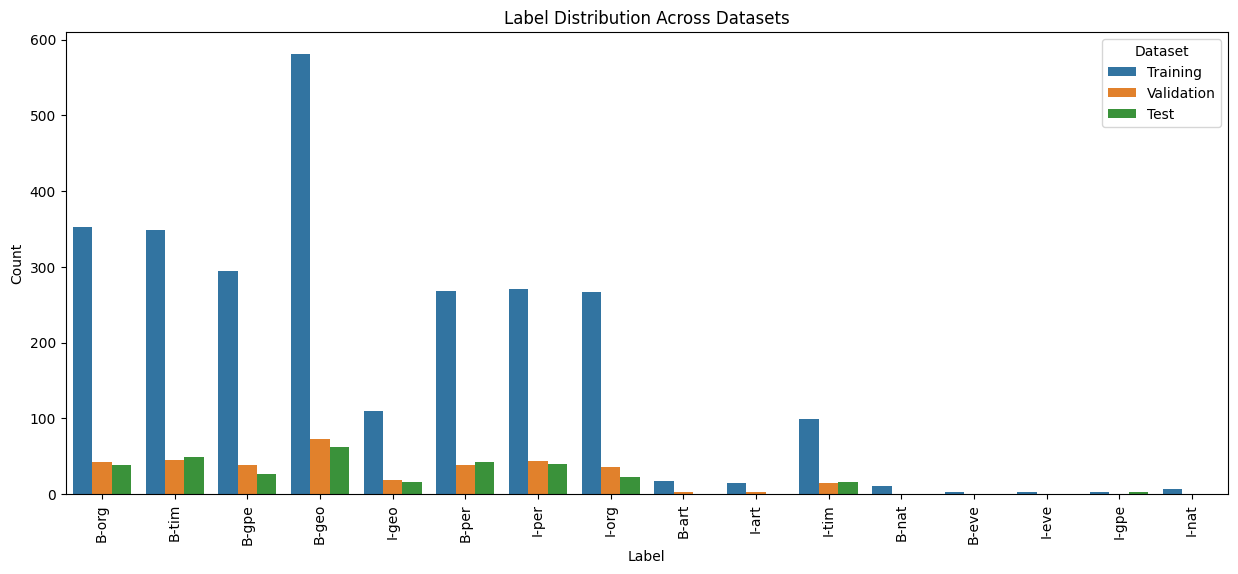

In [32]:
import matplotlib.pyplot as plt
# Plot the distribution
plt.figure(figsize=(15, 6))
sns.barplot(x='Label', y='Count', hue='Dataset', data=df)
plt.title('Label Distribution Across Datasets')
plt.xticks(rotation=90)
plt.show()


In [33]:
# Training the model
optimizer = nlp.resume_training()

In [34]:
# Fine-tuning the model
for i in range(20):
    losses = {}
    batches = minibatch(train_data, size=8)
    for batch in batches:
        texts, annotations = zip(*batch)
        examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)]
        nlp.update(examples, drop=0.35, losses=losses)
    print(f"Iteration {i}: Losses {losses}")

Iteration 0: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 6744.164304474431}
Iteration 1: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 5647.376135010696}
Iteration 2: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 5298.068667535629}
Iteration 3: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 5247.5163785496725}
Iteration 4: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 4259.424813317744}
Iteration 5: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 4150.170418676321}
Iteration 6: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 3958.5153864108393}
Iteration 7: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 3494.3577573181037}
Iteration 8: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 3050.9654826906835}
Iteration 9: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 3275.6778789279724}
Iteration 10: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.

In [35]:
# Save  trained model
nlp.to_disk("custom_ner_model")

In [36]:
# Load  trained model
nlp = spacy.load("custom_ner_model")

In [37]:
#Model Evaluation
def evaluate_model(nlp, data):
    results = []
    for text, annot in data:
        doc = nlp(text)
        true_entities = [(start, end, label) for start, end, label in annot['entities']]
        pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        results.append((true_entities, pred_entities, text))  # Ensure the tuple is in this format
    return results


In [38]:
# Evaluate on validation set
val_results = evaluate_model(nlp, val_data)
# Evaluate on test set
test_results = evaluate_model(nlp, test_data)

In [39]:
def flatten_results_by_token(nlp, results):
    true_labels = []
    pred_labels = []

    for result in results:
        true_entities = result[0]  # Extract true_entities
        pred_entities = result[1]  # Extract pred_entities

        true_dict = {(start, end): label for start, end, label in true_entities}
        pred_dict = {(start, end): label for start, end, label in pred_entities}

        # Collect all unique start positions
        all_starts = sorted(set([start for start, end in true_dict.keys()] + [start for start, end in pred_dict.keys()]))

        for start in all_starts:
            # Use token alignment with start position
            true_label = true_dict.get((start, start+1), 'O')
            pred_label = pred_dict.get((start, start+1), 'O')
            true_labels.append(true_label)
            pred_labels.append(pred_label)

    return true_labels, pred_labels


In [40]:
val_true_labels, val_pred_labels = flatten_results_by_token(nlp, val_results)
test_true_labels, test_pred_labels = flatten_results_by_token(nlp, test_results)

In [41]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score,classification_report
# Calculate classification report for validation set
val_report = classification_report(val_true_labels, val_pred_labels, zero_division=1)
print("Validation Classification Report:")
print(val_report)

# Calculate classification report for test set
test_report = classification_report(test_true_labels, test_pred_labels, zero_division=1)
print("Test Classification Report:")
print(test_report)

Validation Classification Report:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00       372

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372

Test Classification Report:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00       334

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



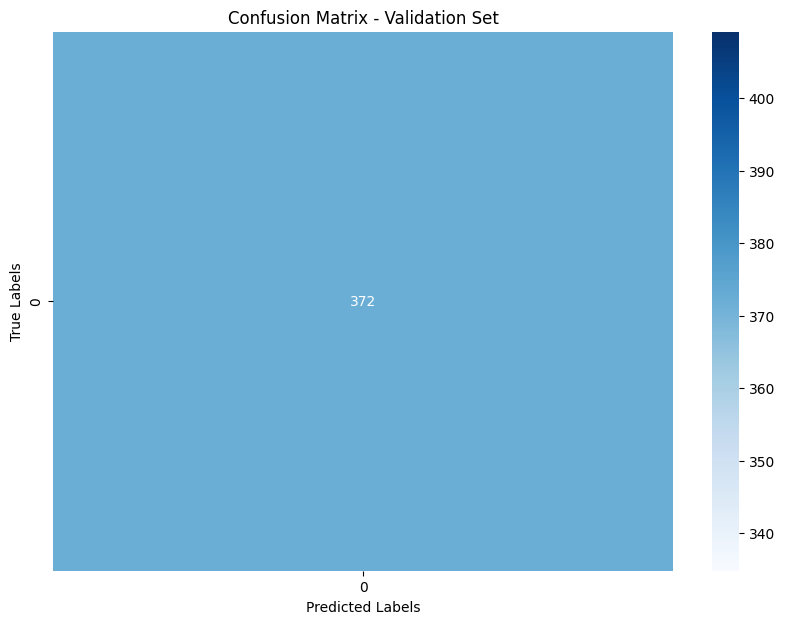

In [42]:
import matplotlib.pyplot as plt
# Confusion Matrix for Validation Set
val_cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()


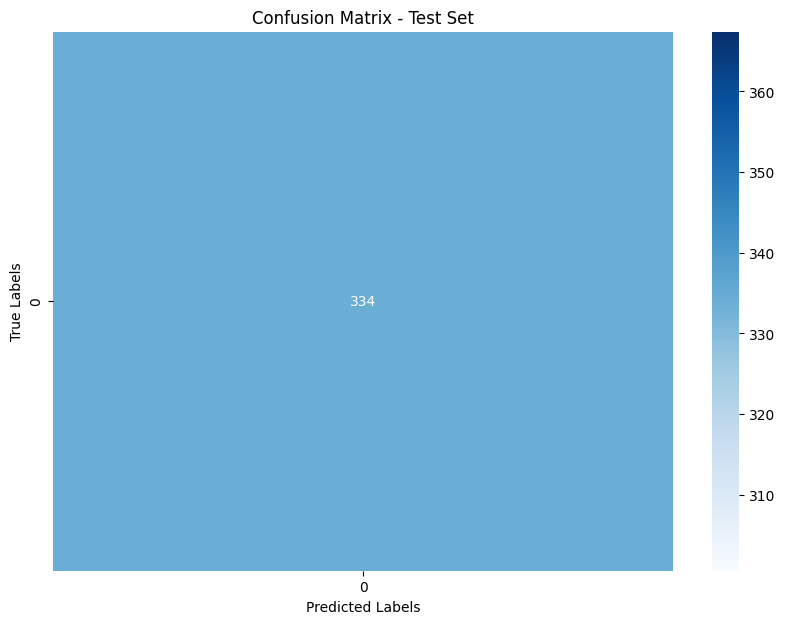

In [43]:
# Confusion Matrix for Test Set
test_cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


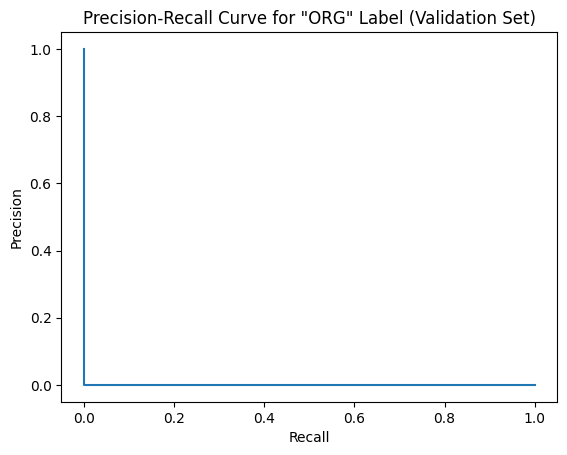

In [45]:
# Precision-Recall Curve (Example for a specific label, adapt as needed)
from sklearn.preprocessing import label_binarize

# Assuming 'ORG' is a label you want to plot
val_true_binary = label_binarize(val_true_labels, classes=['O', 'ORG'])
val_pred_scores = label_binarize(val_pred_labels, classes=['O', 'ORG'])

# Access the correct column (index 0 for the first and only column)
precision, recall, _ = precision_recall_curve(val_true_binary[:, 0], val_pred_scores[:, 0])
average_precision = average_precision_score(val_true_binary[:, 0], val_pred_scores[:, 0])

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for "ORG" Label (Validation Set)')
plt.show()

<ipython-input-46-8179afba0e54>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=pred_df, palette='viridis')


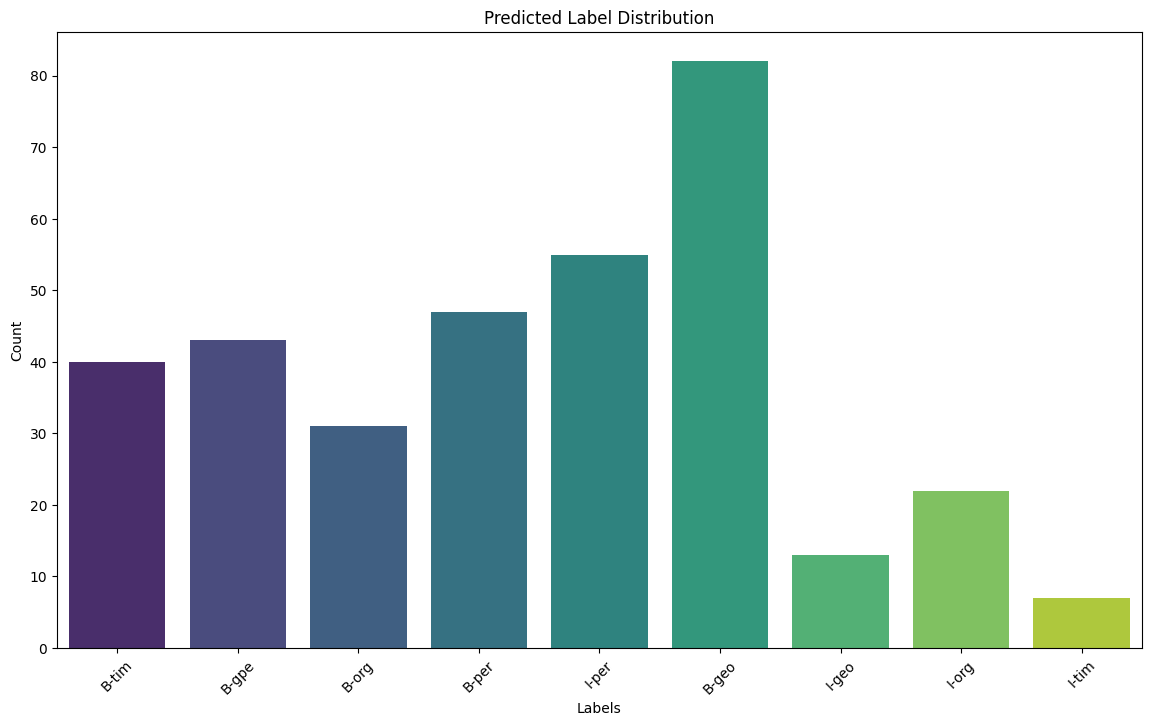

In [46]:
#  labels from predictions
pred_labels = [ent.label_ for doc in nlp.pipe([text for text, _ in val_data]) for ent in doc.ents]

# distribution
pred_distribution = Counter(pred_labels)
pred_df = pd.DataFrame(pred_distribution.items(), columns=['Label', 'Count'])

# Plot distribution
plt.figure(figsize=(14, 8))
sns.barplot(x='Label', y='Count', data=pred_df, palette='viridis')
plt.title('Predicted Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [47]:
from spacy import displacy

def visualize_entities_with_displacy(text, true_entities, pred_entities):
    doc = nlp(text)

    # Set up colors
    colors = {
    "B-eve": "#ff9999",
    "B-geo": "#66b3ff",
    "B-org": "#99ff99",
    "B-tim": "#ffcc99",
    "I-art": "#c2c2f0",
    "I-eve": "#ffb3e6",
    "I-geo": "#c2f0c2",
    "I-org": "#c4e17f",
    "I-per": "#ffb3b3",
    "I-tim": "#b3b3b3"
    }

    # Create annotations for true entities
    true_annotations = {"entities": true_entities}

    # Render true entities
    print("True Entities:")
    displacy.render(doc, style="ent", options={"colors": colors})

    # Create a new Doc object for predictions
    doc_pred = nlp(text)
    doc_pred.ents = [doc_pred.char_span(start, end, label) for start, end, label in pred_entities]

    # Render predicted entities
    print("Predicted Entities:")
    displacy.render(doc_pred, style="ent", options={"colors": colors})

# Example usage
for text, annot in val_data[3:5]:
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents]
    if true_entities or pred_entities:  # Plot only if there are entities to show
        visualize_entities_with_displacy(text, true_entities, pred_entities)
    else:
        print("No entities found in this example.")

True Entities:


Predicted Entities:


True Entities:


Predicted Entities:
